In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels import api as sm
import plotly.subplots as sp
import math
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")

2025-06-06 07:21:41.093969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749194501.374149      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749194501.457346      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/MSFT_2006-01-01_to_2018-01-01.csv')
df.head() 

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,36.496817,36.827903,36.173190,36.513412,5.161762e+07
std,14.683337,14.742483,14.620057,14.694656,3.114958e+07
min,15.200000,15.620000,14.870000,15.150000,7.425603e+06
25%,26.785000,27.045000,26.535000,26.835000,3.136557e+07
50%,29.990000,30.230000,29.780000,30.000000,4.617529e+07
75%,44.545000,44.980000,44.090000,44.400000,6.322291e+07
max,87.120000,87.500000,86.230000,86.850000,5.910786e+08


In [5]:
print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [6]:
df = df.dropna()

print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [7]:
df["Date"] = pd.to_datetime(df["Date"])

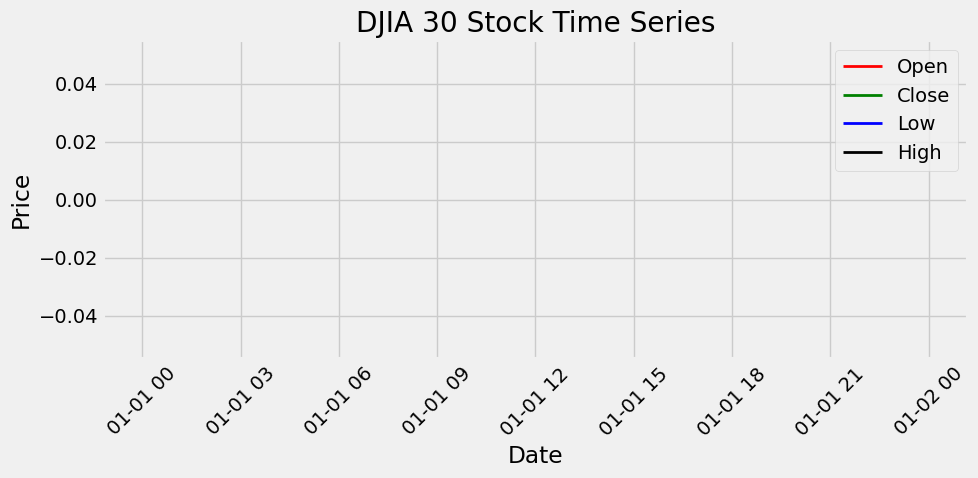

In [8]:
df_AAPL = df[df['Name'] == 'AAPL']

plt.figure(figsize=(10, 5))
plt.plot(df_AAPL['Date'], df_AAPL['Open'], color='red', label='Open', linewidth=2)
plt.plot(df_AAPL['Date'], df_AAPL['Close'], color='green', label='Close', linewidth=2)
plt.plot(df_AAPL['Date'], df_AAPL['Low'], color='blue', label='Low', linewidth=2)
plt.plot(df_AAPL['Date'], df_AAPL['High'], color='black', label='High', linewidth=2)

plt.title("DJIA 30 Stock Time Series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
df.set_index('Date', inplace=True)

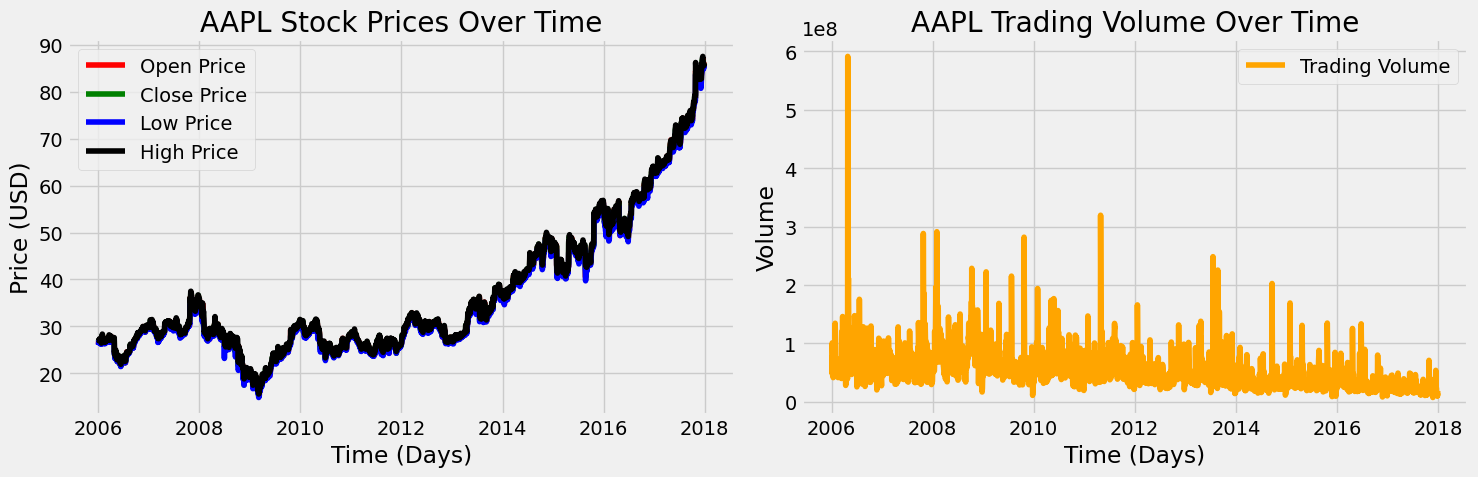

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['Open'], color='red', label='Open Price')
plt.plot(df['Close'], color='green', label='Close Price')
plt.plot(df['Low'], color='blue', label='Low Price')
plt.plot(df['High'], color='black', label='High Price')
plt.title('AAPL Stock Prices Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(df['Volume'], color='orange', label='Trading Volume')
plt.title('AAPL Trading Volume Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Volume')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [11]:
decomposition_result = seasonal_decompose(df['Close'], model='additive', period=365)

subplot_titles = ['Observed Prices', 'Trend Component', 'Seasonal Component', 'Residuals']

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=subplot_titles)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.observed, 
                         mode='lines', name='Observed Prices',
                         line=dict(color='blue', width=2)), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.trend, 
                         mode='lines', name='Trend',
                         line=dict(color='orange', width=2)), row=2, col=1)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.seasonal, 
                         mode='lines', name='Seasonal',
                         line=dict(color='green', width=2)), row=3, col=1)

fig.add_trace(go.Scatter(x=df.index, y=decomposition_result.resid, 
                         mode='lines', name='Residual',
                         line=dict(color='red', width=2)), row=4, col=1)

fig.update_layout(height=800, title='Decomposed Analysis of Closing Prices',
                  xaxis_title='Date', yaxis_title='Value', showlegend=True)

fig.show()

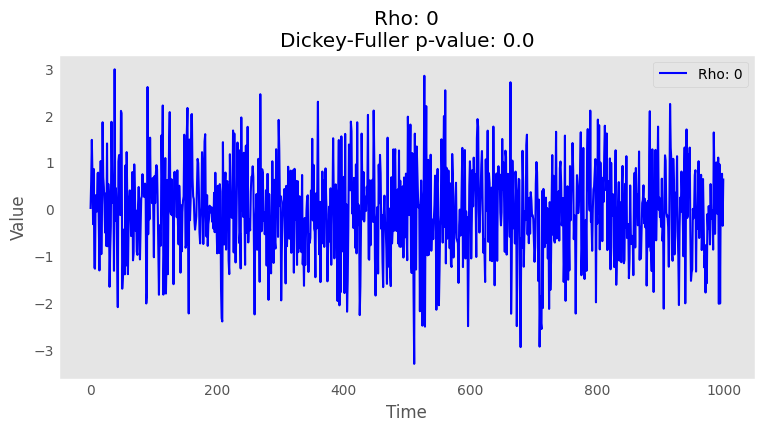

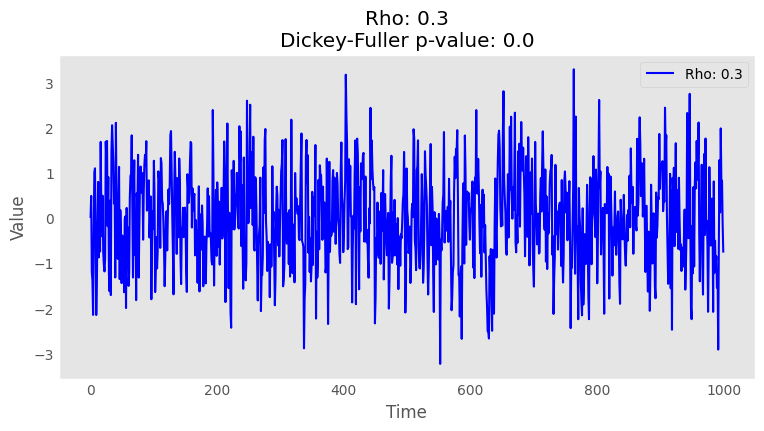

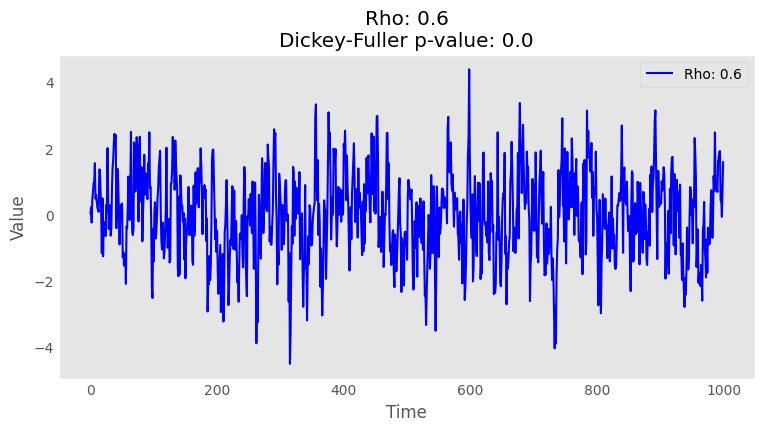

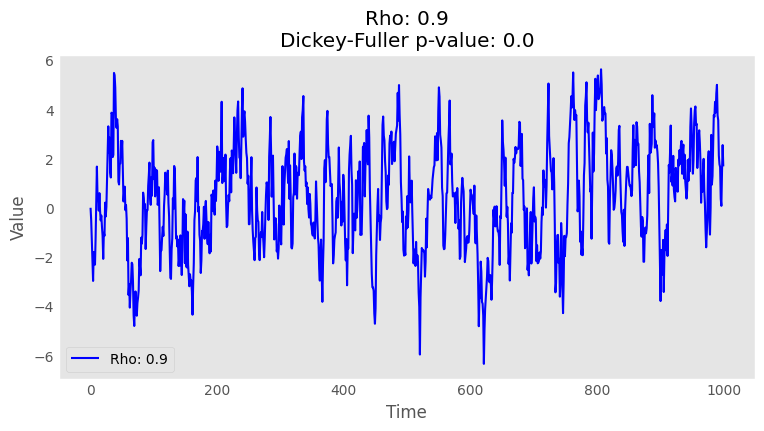

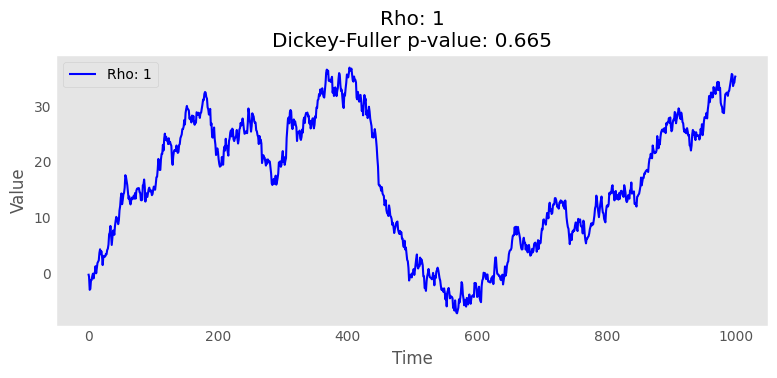

In [12]:
def plotProcess(n_samples=1000, rho=0): 
    w = np.random.normal(size=n_samples)
    x = np.zeros(n_samples)  
    
    for t in range(1, n_samples):  
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('ggplot'):  
        plt.figure(figsize=(8, 4)) 
        plt.plot(x, label=f"Rho: {rho}", linewidth=1.5, color='blue')  
        plt.title(f"Rho: {rho}\nDickey-Fuller p-value: {round(sm.tsa.stattools.adfuller(x)[1], 3)}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()

for rho in [0, 0.3, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

plt.tight_layout() 
plt.show()

In [13]:
df = df.drop(['Name'], axis=1)

In [14]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,26.25,27.00,26.10,26.84,79974418
2006-01-04,26.77,27.08,26.77,26.97,57975661
2006-01-05,26.96,27.13,26.91,26.99,48247610
2006-01-06,26.89,27.00,26.49,26.91,100969092
2006-01-09,26.93,27.07,26.76,26.86,55627836


In [15]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [16]:
train = df[:'2016'].iloc[:,1:2].values
test = df['2017':].iloc[:,1:2].values

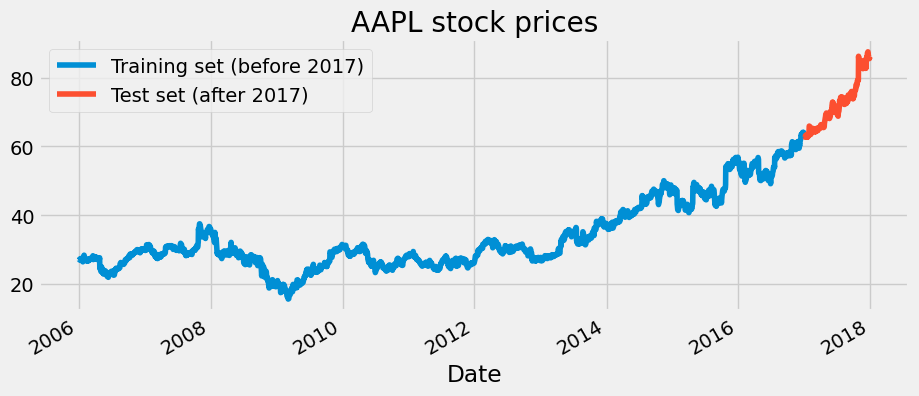

In [17]:
df["High"][:'2016'].plot(figsize=(10,4), legend=True)
df["High"]["2017":].plot(figsize=(10,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (after 2017)"])
plt.title("AAPL stock prices")
plt.show()

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

In [19]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [20]:
time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [21]:
def prepare_and_predict(model, data, scaler, time_step):
    """
    Prepares the input data for the model and makes predictions.

    Parameters:
    model: The trained model (e.g., LSTM_model, RNN_model, etc.)
    data: The original data (Pandas DataFrame) to get the high prices from.
    scaler: The scaler used for normalization (MinMaxScaler).
    time_step: The number of time steps to consider for the LSTM/RNN model.

    Returns:
    predicted_prices: The predicted prices after inverse transformation.
    """
    inputs = data["High"][len(data) - len(test) - time_step:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(time_step, len(inputs)):
        X_test.append(inputs[i-time_step:i, 0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    return predicted_prices

In [22]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  
LSTM_model.add(Dropout(0.3)) 
LSTM_model.add(LSTM(units=100, return_sequences=True))  
LSTM_model.add(Dropout(0.3))  
LSTM_model.add(LSTM(units=100, return_sequences=False))  
LSTM_model.add(Dropout(0.3))  
LSTM_model.add(Dense(units=1))

2025-06-06 07:22:03.464731: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

LSTM_model.fit(X_train, y_train, epochs=15, batch_size=32) 

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - loss: 0.0299
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - loss: 0.0022
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 0.0024
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.0019
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.0022
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - loss: 0.0024
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 0.0016
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 0.0020
Epoch 9/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.0015
Epoch 10/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 0.0016
Epoch 11/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.0014
Epoch 12/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - loss: 0.0014
Epoch 13/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 0.0013
Epoch 14/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - loss: 0.0013
Epoch 15/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


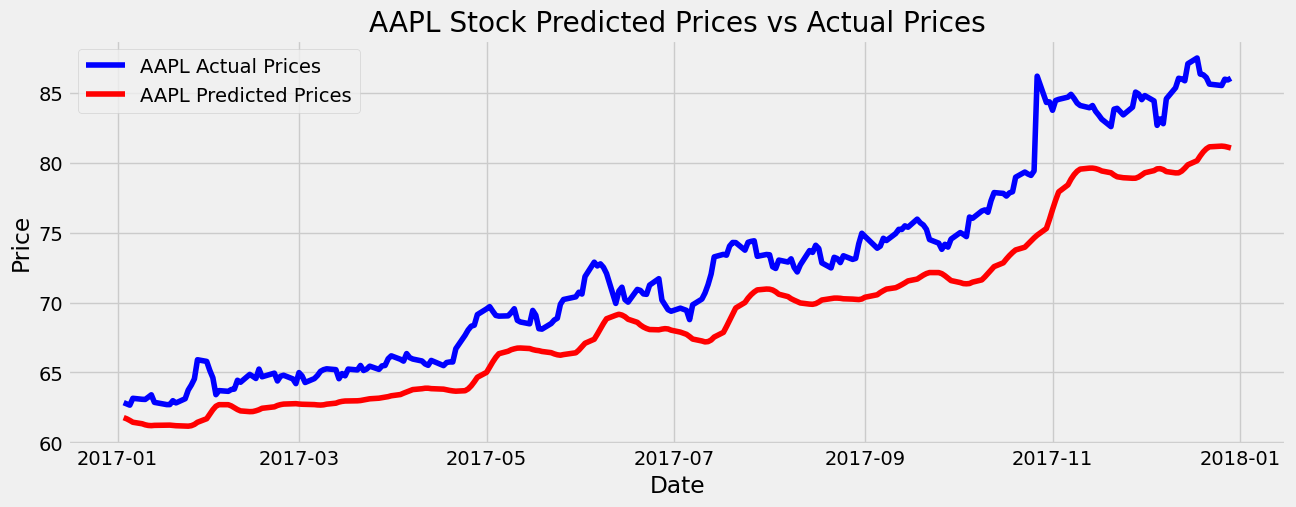

the root mean squared error is : 3.723598306409678.


In [24]:
predicted_prices = prepare_and_predict(LSTM_model, df, scaler, time_step)

plt.figure(figsize=(14, 5))
plt.plot(df.loc['2017':].index, test, color='blue', label='AAPL Actual Prices')
plt.plot(df.loc['2017':].index, predicted_prices, color='red', label='AAPL Predicted Prices')
plt.title("AAPL Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

return_rmse(test, predicted_prices)

In [25]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))) 
RNN_model.add(Dropout(0.3))  
RNN_model.add(SimpleRNN(units=100, return_sequences=True))  
RNN_model.add(Dropout(0.3))  
RNN_model.add(SimpleRNN(units=100, return_sequences=False)) 
RNN_model.add(Dropout(0.3))  
RNN_model.add(Dense(units=1))

In [26]:
RNN_model.compile(optimizer='adam', loss='mean_squared_error')

RNN_model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.5158
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.1587
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0569
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0290
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0196
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0130
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0114
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0086
Epoch 9/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0074
Epoch 10/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0060
Epoch 11/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0047
Epoch 12/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0054
Epoch 13/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0042
Epoch 14/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0039
Epoch 15/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0041
Epo

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


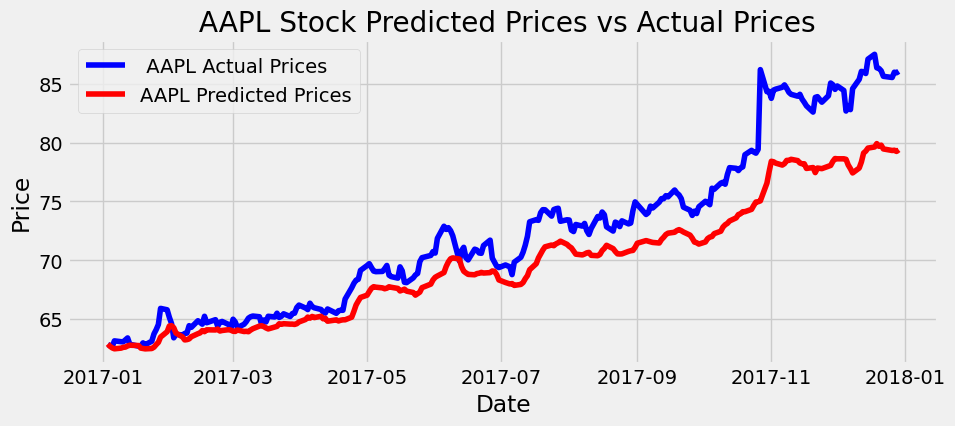

the root mean squared error is : 3.371461594328492.


In [27]:
predicted_prices = prepare_and_predict(RNN_model, df, scaler, time_step)

real_prices = df['2017':].iloc[:, 1:2].values  

plt.figure(figsize=(10, 4))
plt.plot(df.loc['2017':].index, test, color='blue', label=' AAPL Actual Prices')
plt.plot(df.loc['2017':].index, predicted_prices, color='red', label='AAPL Predicted Prices')
plt.title(" AAPL Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.show()

return_rmse(test, predicted_prices)

In [28]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    return model

GRU_model = create_gru_model((X_train.shape[1], 1))

In [29]:
GRU_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), 
                  loss='mean_squared_error')

GRU_model.fit(X_train, y_train, epochs=15, batch_size=150)  

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - loss: 0.0918
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0371
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0217
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0084
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0030
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - loss: 0.0027
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0024
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0021
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0022
Epoch 10/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0018
Epoch 11/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0021
Epoch 12/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - loss: 0.0020
Epoch 13/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 0.0018
Epoch 14/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - loss: 0.0019
Epoch 15/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - l

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step


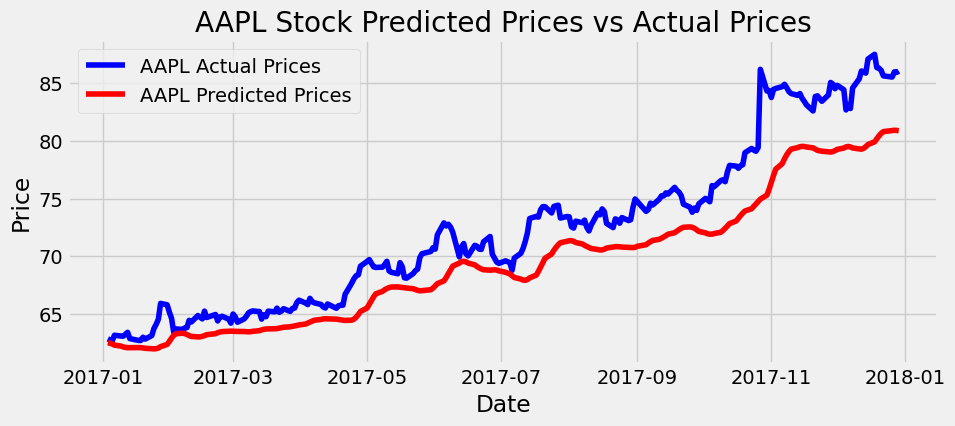

the root mean squared error is : 3.436126344404216.


In [30]:
predicted_prices = prepare_and_predict(GRU_model, df, scaler, time_step)

real_prices = df['2017':].iloc[:, 1:2].values  

plt.figure(figsize=(10, 4))
plt.plot(df.loc['2017':].index, real_prices, color='blue', label='AAPL Actual Prices')  
plt.plot(df.loc['2017':].index, predicted_prices, color='red', label='AAPL Predicted Prices')  
plt.title("AAPL Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

return_rmse(test, predicted_prices)